# Image Dataset Drift 


This notebooks provides an overview for using and understanding the image dataset drift check, used to detect drift in simple image properties between train and test datasets.

**Structure:**

- [What is a dataset drift?](#what_is_dataset_drift)
- [Loading the data](#load_data_model)
- [Run the check](#run_check)
- [Define a condition](#define_condition)


<a id='what_is_dataset_drift'></a>
## What is a dataset drift?

Data drift is simply a change in the distribution of data over time. It is also one of the top reasons of a machine learning model performance degrades over time.

Specifically, a whole dataset drift, or a multivariate dataset drift, occurs when there is a change in the relation between input features.

Causes of data drift include:

- Natural drift in the data, such as lighting (brightness) changes between summer and winter.
- Upstream process changes, such as a camera being replaced that has a different lens, which makes images sharper.
- Data quality issues, such as a malfunctioning camera that always returns a black image.
- Data pipeline errors, such as a change in image augmentations done in preprocessing.

In the context of machine learning, drift between the training set and the test set which is not due to augmentation will likely make the model prone to error. In other words, if the model was trained on data that is different from the current test data, it will probably make more mistakes predicting the target variable.

### How deepchecks detects dataset drift

There are many methods to detect feature drift. Some of them are statistical methods that aim to measure difference between distribution of 2 given sets. This methods are more suited to univariate distributions and are primarily used to detect drift between 2 subsets of a single feature.

Measuring a multivariate data drift is a bit more challenging. In the image dataset drift check, the multivariate drift is measured by training a classifier that detects which samples come from a known distribution and defines the drift by the accuracy of this classifier. 

Practically, the check concatanates the train and the test sets, and assigns label 0 to samples that come from the training set, and 1 to those who are from the test set. Then, we train a binary classifer of type [Histogram-based Gradient Boosting Classification Tree](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html), and measure the drift score from the AUC score of this classifier.

As the classifier is a tree model, that cannot run on the images themselves, the check calculates properties for each image (such as brightness, aspect ratio etc.) and uses them as input features to the classifier.

### Imports

In [1]:
import numpy as np

from deepchecks.vision.dataset import VisionData
from deepchecks.vision.checks import ImageDatasetDrift

<a id='load_data_model'></a>
## Loading the data

In [2]:
from deepchecks.vision.datasets.detection.coco import load_dataset

train_dataloader = load_dataset(train=True)
test_dataloader = load_dataset(train=False)

Create custom formatter to read coco dataset (comes as PIL Images):

In [3]:
def pil_formatter(batch):
    return [np.array(img) for img in batch[0]]

Define train and tests VisionData classes:

In [4]:
from deepchecks.vision.utils.image_formatters import ImageFormatter
from deepchecks.vision.utils.detection_formatters import DetectionLabelFormatter

train_ds = VisionData(train_dataloader, image_formatter=ImageFormatter(pil_formatter), label_formatter=DetectionLabelFormatter(lambda x: x))
test_ds = VisionData(train_dataloader, image_formatter=ImageFormatter(pil_formatter), label_formatter=DetectionLabelFormatter(lambda x: x))

<a id='run_check'></a>
## Run the check

### without drift

In [5]:
check = ImageDatasetDrift()
check.run(train_dataset=train_ds, test_dataset=test_ds)

Image Dataset Drift Calculate drift between the entire train and test datasets (based on image properties) using a trained model. Read More... Additional Outputs ✓ Nothing found

### Insert drift

In [13]:
def add_brightness(img):
    reverse = 255 - img
    addition_of_brightness = (reverse * 0.07).astype(int)
    return img + addition_of_brightness

def pil_drift_formatter(batch):
    return [add_brightness(np.array(img)) for img in batch[0]]

In [14]:
# Use the pil_drift_formatter to insert extra brightness to the train dataset:
train_ds = VisionData(train_dataloader, image_formatter=ImageFormatter(pil_drift_formatter), label_formatter=DetectionLabelFormatter(lambda x: x))
test_ds = VisionData(test_dataloader, image_formatter=ImageFormatter(pil_formatter), label_formatter=DetectionLabelFormatter(lambda x: x))

### Run the check again

Image Dataset Drift Calculate drift between the entire train and test datasets (based on image properties) using a trained model. Read More... Additional Outputs 
 
 The shown features are the image properties (brightness, aspect ratio, etc.) that are most important for the
 domain classifier - the domain_classifier trained to distinguish between the train and test datasets. 
 
 
 
 The percents of explained dataset difference are the importance values for the feature calculated
 using `permutation_importance`.

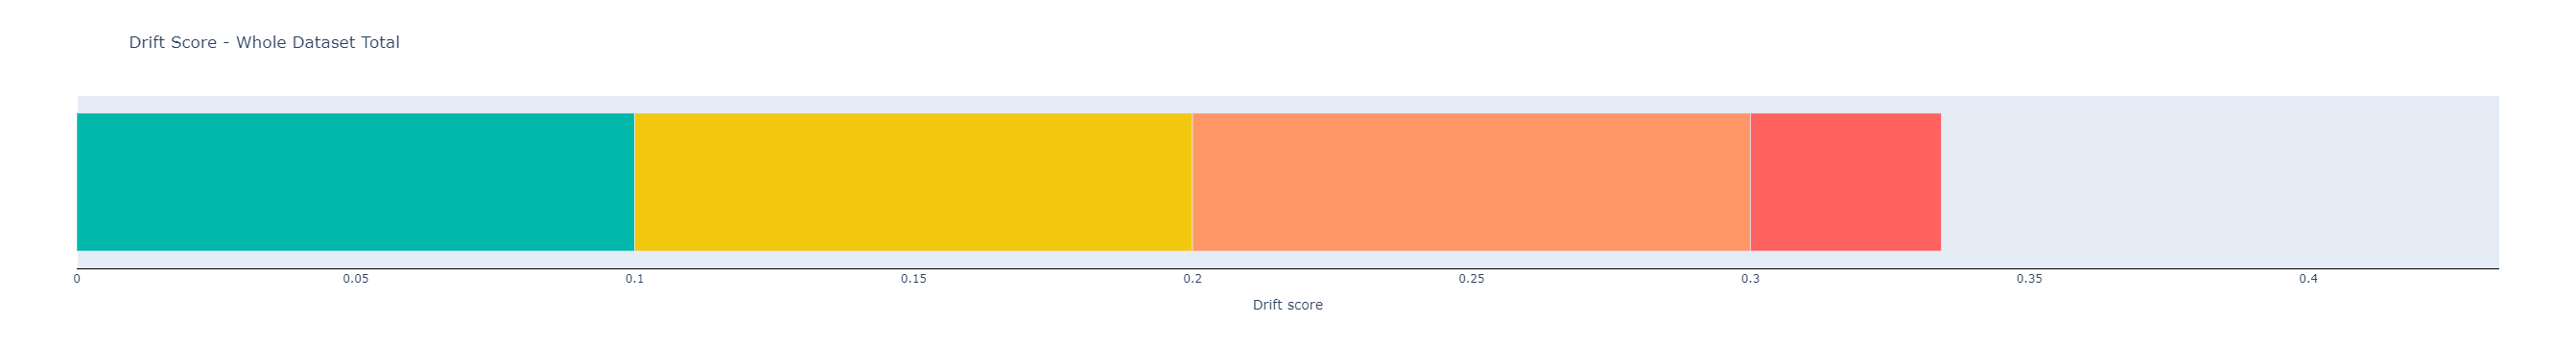

Main features contributing to drift * showing only the top 3 columns, you can change it using n_top_columns param

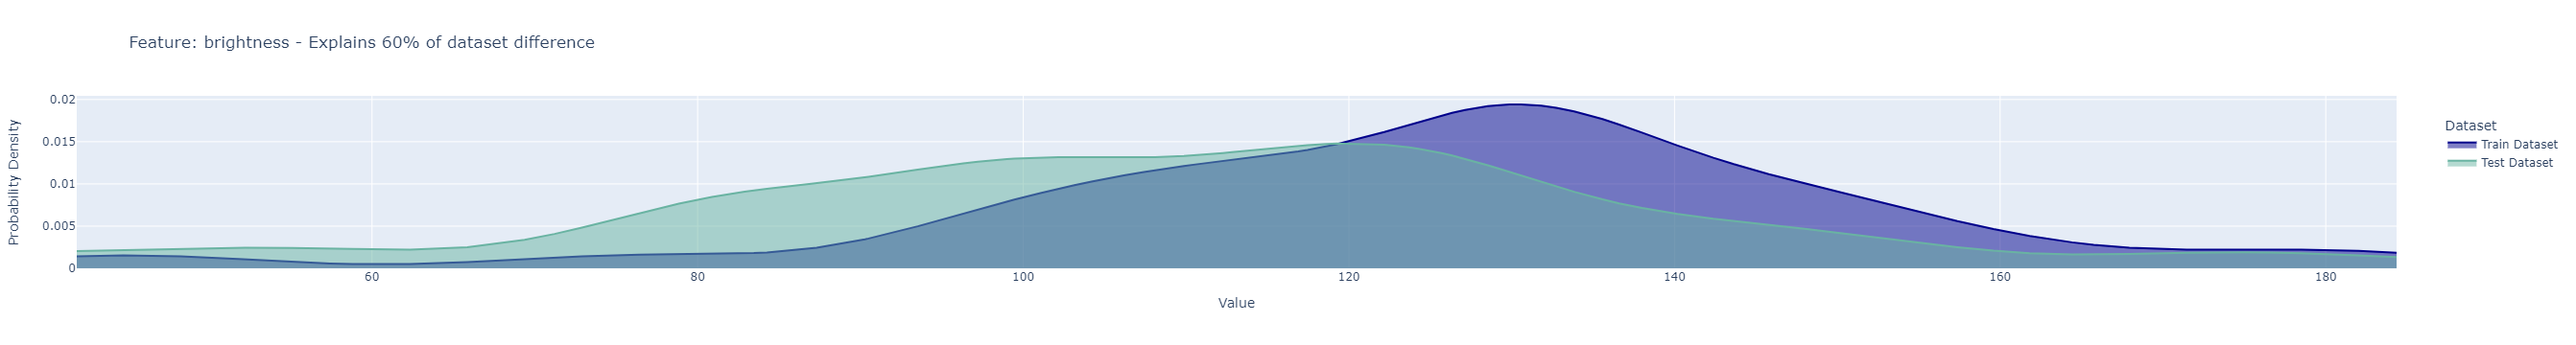

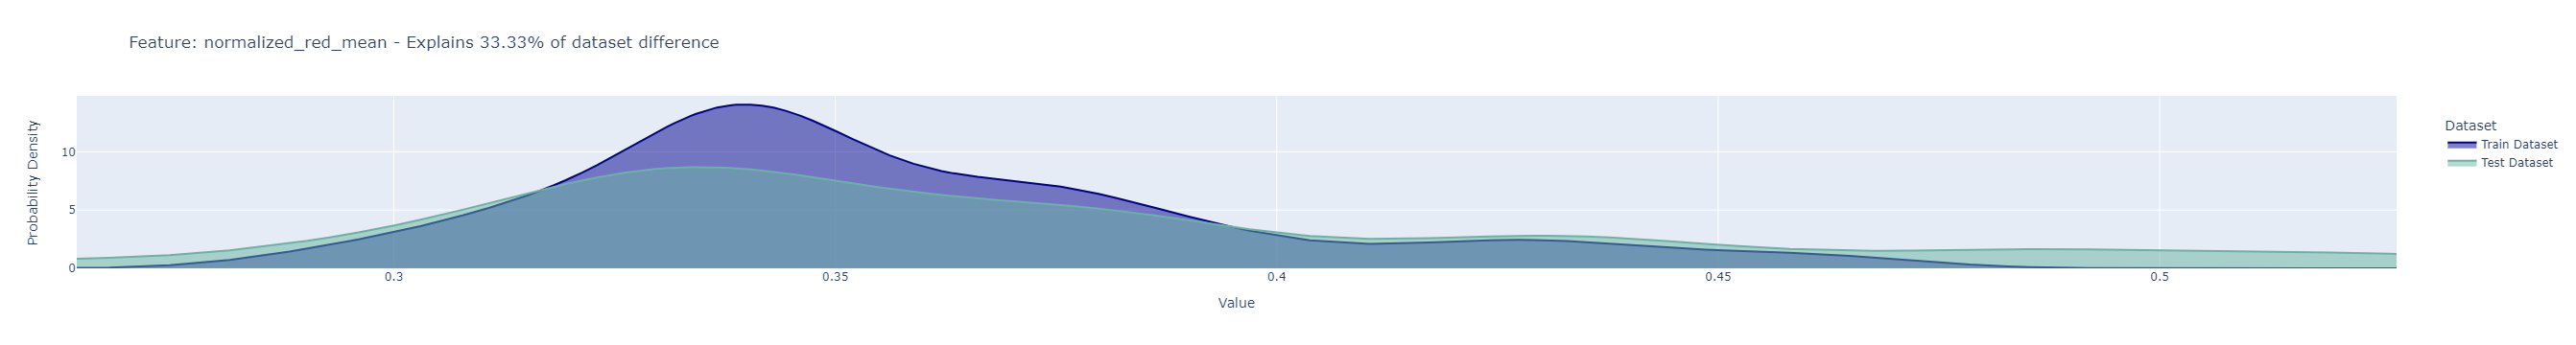

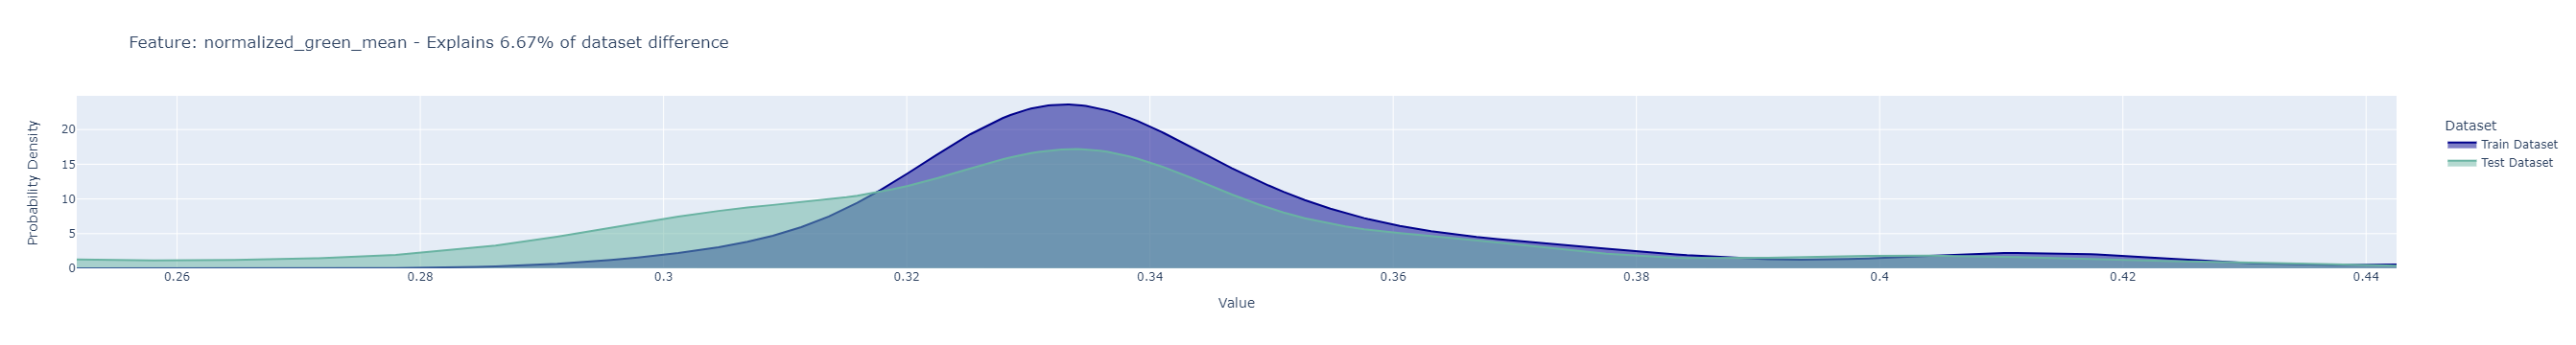

In [15]:
check = ImageDatasetDrift()
check.run(train_dataset=train_ds, test_dataset=test_ds)